# Point Spread Function and StarFinder


경기과학고등학교 관측천문학 강좌를 위해 만들었으며  <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">크리에이티브 커먼즈 저작자표시-비영리-동일조건변경허락 4.0 국제 라이선스</a>에 따라 이용할 수 있음.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="크리에이티브 커먼즈 라이선스" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>


# `photutils` Annulus Background

sky annulus를 사용하여 sky background 를 추정하는 것이 가장 널리 사용되어 왔는데 그 과정은 다음과 같다. 

1. Set the annulus based on FWHM. 
2. Get the statistics of the sky in the annulus: sky value and its error.

이전에 Star finder에서 사용했던 preprocessing 이 완료된 [example file](https://drive.google.com/file/d/154vZIQRABEujYlFGBASl7-ePrduS7FrO/view?usp=sharing) 을 다시 이용해 보자. 

1. Get FWHM from `MaximDL` (it was ~ 2.5 pix)
2. Find stars from `DAOStarFinder` using `100*sky_sigma` threshold. (very strong constrain)
3. Make circular annuli with inner/outer radius of `4*FWHM` and `6*FWHM`, centered at each star.
4. Do 3-sigma clipping with 10 iterations for each annulus, and get the median and standard deviation.
5. To mimic SExtractor, I will choose `sky` as 
```python
# pseudo code
mean, median, std = sigma_clipped_stats(sky_annulus, sigma=3, iters=10)
condition = ((2.5 * median - 1.5 mean) > 0.3 std)
if condition:
    msky = median
else
    msky = 2.5 * median - 1.5 mean
```
6. If the standard deviation is $s_s=$`std`, this will be used for the flux error of the source:
$$ \Delta N = \sqrt{ N + n_a (m_s + R^2) + \frac{n_a^2 s_s^2}{n_s}} $$

* **TIP**: I have used `sigma_clipped_stats` in the pseudo code, which returns the standard deviation ($s_s$) using $\sqrt{\sum (x_i - \bar{x})^2/N}$, **not** using $N-1$. If the sky is known to be Gaussian, which is rarely the case, it is desirable to use this `std` as $s_s$ (due to maximum likelihood issue). But if it is not, then we MUST multiply the factor $\sqrt{(N)/(N-1)}$ to get the desired $s_s$. If you use the `std` without this correction, you are **underestimating** the error, since *that* `std` is derived from the assumption that you know sky is Gaussian. *That* `std` is smaller than the *desired* `std` because it is for the use when you know more about the sky (i.e., Gaussian distribution).


### Steps 1, 2, 3 Finding stats and Making Annulus

앞서 배웠던 코드를 응용하여 별을 찾아서 Annulus를 그려보자.


In [1]:
#%%
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.stats import sigma_clip, sigma_clipped_stats
from photutils import DAOStarFinder
from photutils import CircularAperture as CircAp
from photutils import CircularAnnulus as CircAn
from photutils import aperture_photometry as APPHOT
#%%
dir_name = '20170220_m35/'
f_name = 'g3035794_p.fits'

hdu = fits.open(dir_name+f_name)
img = np.array(hdu[0].data[300:800, 1100:1700]/65536.0, dtype=np.float32)

# if image value < 10^(-6), replace the pixel as 10^(-6)
img[img < 1.e-6] = 1.e-6

FWHM   = 2.7
sky_th = 100    # sky_th * sky_sigma will be used for detection lower limit : sky_th = 5

# What if we do "sigma-clip" than MAD?
sky_a, sky_m, sky_s_sc = sigma_clipped_stats(img) # default is 3-sigma, 5 iters
thresh = sky_th*sky_s_sc
print('3 sigma 5 iters clipped case:')
print('{0:8.6f} x {1:4d}   =   {2:8.6f}\n'.format(sky_s_sc, sky_th, thresh))

DAOfind = DAOStarFinder(fwhm=FWHM, threshold=thresh, 
                        sharplo=0.2, sharphi=3.0,  # default values: sharplo=0.2, sharphi=1.0,
                        roundlo=-1.0, roundhi=1.0,  # default values: roundlo=-1.0, roundhi=1.0,
                        sigma_radius=1.5,          # default values: sigma_radius=1.5,
                        ratio=0.9,                 # 1.0: circular gaussian:  ratio=1.0,
                        exclude_border=True)       # To exclude sources near edges : exclude_border=True

# The DAOStarFinder object ("DAOfind") gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
DAOfound = DAOfind(img)

if len(DAOfound)==0 :
    print ('No star was founded using DAOStarFinder\n'*3)
else : 
    # Use the object "found" for aperture photometry:
    print (len(DAOfound), 'stars were founded')
    #print('DAOfound \n', DAOfound)
    DAOfound.pprint(max_width=1800)
    # save XY coordinates:
    DAOfound.write(dir_name+f_name[:-5]+'_DAOStarFinder.csv', overwrite=True, format='ascii.fast_csv')
    DAOcoord = (DAOfound['xcentroid'], DAOfound['ycentroid']) 
    DAOannul = CircAn(positions=DAOcoord, r_in=4*FWHM, r_out=6*FWHM)
    
    # Save apertures as circular, 4 pixel radius, at each (X, Y)
    DAOapert = CircAp(DAOcoord, r=4.)  
    #print('DAOapert\n ', DAOapert)
    
    DAOimgXY = np.array(DAOcoord)
    #print('DAOimgXY \n', DAOimgXY)
    
    plt.figure(figsize=(12,12))
    ax = plt.gca()
    im = plt.imshow(img, vmax=0.35, origin='lower')
    DAOannul.plot(color='red', lw=2., alpha=0.7)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

DELMAG   =   0.0000            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]


3 sigma 5 iters clipped case:
0.004250 x  100   =   0.425048

21 stars were founded
 id     xcentroid          ycentroid           sharpness           roundness1            roundness2       npix sky        peak               flux                 mag         
--- ------------------ ------------------ ------------------- -------------------- ---------------------- ---- --- ------------------ ------------------ ---------------------
  1 369.66076607921025  48.74640436331067 0.49772213001587345  0.17829365552441911    0.09445919249284787   25 0.0 0.7817535400390625   1.17203459563049  -0.17235107798860816
  2 214.80614723081484  70.87584666588063  0.4553294642259009   0.1626232267362356      0.124166150841904   25 0.0 0.7805938720703125 1.1909403253732875  -0.18972500192193636
  3  510.8970131458162  70.63947938092609  0.3947143236816323  0.19387500230999186    0.13266624443773958   25 0.0 0.7769622802734375 1.1911366532615366   -0.1899039720380747
  4   98.1700349394943  73.91611691506917

<Figure size 1200x1200 with 2 Axes>

### Digress: `ApertureMask`

이제 annulus 를 얻었으면 통계값을 구해보자. 여기에서 `.to_mask` 속성을 이용해 볼 수 있다. `.cutout(img)`는  annulus를 포함하는 영역을 `2*r_out=30` pixel의 크기로 잘라준다.


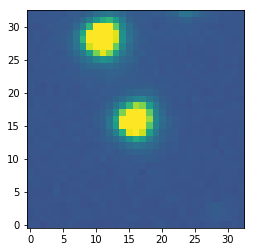

In [2]:
#%%
# since our `DAOannul` has many elements, let me use [1] to use only the 4th annulus:
mask_annul = (DAOannul.to_mask(method='center'))[1]
# CAUTION!! YOU MUST USE 'center', NOT 'exact'!!!

cutimg = mask_annul.cutout(img)
plt.imshow(cutimg, vmin=0.1, vmax=0.35, origin='lower')
plt.show()


이 annulus를 이미지에 적용하여 cutimg와 같은 크기의 배열에서 annulus를 제외한 pixel의 value는 0인 배열을 얻을 수 있다. 


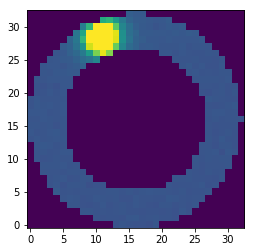

In [3]:
#%%
sky_apply  = mask_annul.multiply(img)  # change from 'sky_apply  = mask_annul.apply(img)'
plt.imshow(sky_apply, origin='lower', vmin=0.1, vmax=0.35)
plt.show()


### Step 4: Sigma Clipping to Sky

annulus pixel의 statistics value 를 구하기 위하여 sky_apply의 0 이 아닌 pixel 만 저장하여 계산을 해 보자. (평균, 중앙값, 표준 편차 등)


In [4]:
#%%
#Returns magnitude from flux.
def mag_inst(flux, ferr):
    m_inst = -2.5 * np.log10(flux)
    merr   = 2.5/np.log(10) * ferr / flux
    return m_inst, merr

def sky_fit(all_sky, method='mode', sky_nsigma=3, sky_iter=5, \
            mode_option='sex', med_factor=2.5, mean_factor=1.5):
    '''
    Estimate sky from given sky values.

    Parameters
    ----------
    all_sky : ~numpy.ndarray
        The sky values as numpy ndarray format. It MUST be 1-d for proper use.
    method : {"mean", "median", "mode"}, optional
        The method to estimate sky value. You can give options to "mode"
        case; see mode_option.
        "mode" is analogous to Mode Estimator Background of photutils.
    sky_nsigma : float, optinal
        The input parameter for sky sigma clipping.
    sky_iter : float, optinal
        The input parameter for sky sigma clipping.
    mode_option : {"sex", "IRAF", "MMM"}, optional.
        sex  == (med_factor, mean_factor) = (2.5, 1.5)
        IRAF == (med_factor, mean_factor) = (3, 2)
        MMM  == (med_factor, mean_factor) = (3, 2)

    Returns
    -------
    sky : float
        The estimated sky value within the all_sky data, after sigma clipping.
    std : float
        The sample standard deviation of sky value within the all_sky data,
        after sigma clipping.
    nsky : int
        The number of pixels which were used for sky estimation after the
        sigma clipping.
    nrej : int
        The number of pixels which are rejected after sigma clipping.
    -------

    '''
    sky = all_sky.copy()
    if method == 'mean':
        return np.mean(sky), np.std(sky, ddof=1)

    elif method == 'median':
        return np.median(sky), np.std(sky, ddof=1)

    elif method == 'mode':
        sky_clip   = sigma_clip(sky, sigma=sky_nsigma, iters=sky_iter)
        sky_clipped= sky[np.invert(sky_clip.mask)]
        nsky       = np.count_nonzero(sky_clipped)
        mean       = np.mean(sky_clipped)
        med        = np.median(sky_clipped)
        std        = np.std(sky_clipped, ddof=1)
        nrej       = len(all_sky) - len(sky_clipped)

        if nrej < 0:
            raise ValueError('nrej < 0: check the code')

        if nrej > nsky: # rejected > survived
            raise Warning('More than half of the pixels rejected.')

        if mode_option == 'IRAF':
            if (mean < med):
                sky = mean
            else:
                sky = 3 * med - 2 * mean

        elif mode_option == 'MMM':
            sky = 3 * med - 2 * mean

        elif mode_option == 'sex':
            if (mean - med) / std > 0.3:
                sky = med
            else:
                sky = (2.5 * med) - (1.5 * mean)
        else:
            raise ValueError('mode_option not understood')

        return sky, std, nsky, nrej



이 코드는 sky background value, standard deviation, the number of sky pixels used, and the number of rejected sky pixels 를 계산해 주는 함수이다. 위에서 얻은 annulus에 이 함수를 적용해 보자. 

In [5]:
#%%
sky_apply  = mask_annul.multiply(img)
sky_non0   = np.nonzero(sky_apply)
sky_pixel  = sky_apply[sky_non0]
msky, sky_std, nsky, nrej = sky_fit(sky_pixel, method='mode', mode_option='sex')
print(msky, sky_std, nsky, nrej)


0.16609772639488105 0.0018943212279716008 402 60


즉, sky background value는 초당 0.1660 electrons per second 이며, 402 개의 sky background pixel (3 시그마 10 반복 반복에 의해 거부 된 60 개)의 sample standard deviation 은 0.00752 이다.


Star ID    msky  sky_std  nsky nrej
0: 0.16421 0.00157  449   5
1: 0.16610 0.00189  402  60
2: 0.16384 0.00148  463   2
3: 0.16679 0.00143  458   2
4: 0.16651 0.00279  383  76
5: 0.16980 0.00147  451   5
6: 0.16606 0.00155  451   2
7: 0.16740 0.00211  396  66
8: 0.16649 0.00141  434  17
9: 0.16930 0.00150  448   2
10: 0.16823 0.00153  440   7
11: 0.17269 0.00157  441  10
12: 0.16768 0.00163  422  25
13: 0.16971 0.00175  420  39
14: 0.17079 0.00165  435  28
15: 0.16905 0.00159  454   7
16: 0.17086 0.00194  412  48
17: 0.17228 0.00160  457   2
18: 0.17477 0.00162  418  41
19: 0.17344 0.00146  447  13
20: 0.17545 0.00142  259   8


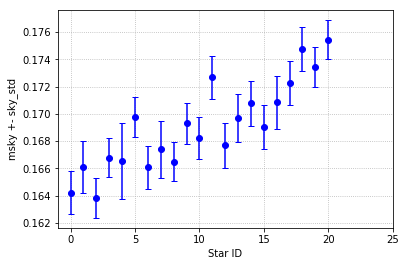

In [6]:
#%%
N_stars = len(DAOfound)
print('Star ID    msky  sky_std  nsky nrej')

for i in range(0, N_stars):
    mask_annul = (DAOannul.to_mask(method='center'))[i]
    sky_apply  = mask_annul.multiply(img)
    sky_non0   = np.nonzero(sky_apply)
    sky_pixel  = sky_apply[sky_non0]
    msky, sky_std, nsky, nrej = sky_fit(sky_pixel, method='mode', mode_option='sex')
    print('{0}: {1:.5f} {2:.5f} {3:4d} {4:3d}'.format(i, msky, sky_std, nsky, nrej))
    plt.errorbar([i], msky, yerr=sky_std, capsize=3, marker='o', color='b')

plt.xlabel('Star ID')
plt.ylabel('msky +- sky_std')
plt.xticks(np.arange(0, N_stars+5, step=5))
plt.grid(ls=':')
plt.show()


하늘의 background 값이 곳에 따라 일부 위치 조금씩은 다를 수 있지만 전반적으로 비슷한 값을 보인다. 

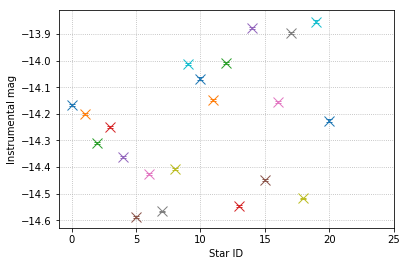

ID, Msky, sky_std, Sky count Pixel_N, Sky reject Pixel_N, mag_ann, merr_ann
0, 10761.84855, 103.16273,  449,   5, -14.165, 0.004
1, 10885.38060, 124.14624,  402,  60, -14.202, 0.004
2, 10737.62635, 97.00850,  463,   2, -14.311, 0.004
3, 10930.81987, 94.02212,  458,   2, -14.250, 0.004
4, 10912.56397, 182.64647,  383,  76, -14.361, 0.004
5, 11127.90576, 96.26705,  451,   5, -14.588, 0.003
6, 10883.19734, 101.69152,  451,   2, -14.426, 0.003
7, 10970.63636, 138.17893,  396,  66, -14.567, 0.003
8, 10910.88940, 92.69040,  434,  17, -14.407, 0.003
9, 11095.11384, 98.07838,  448,   2, -14.014, 0.005
10, 11024.98523, 100.31639,  440,   7, -14.067, 0.004
11, 11317.48980, 103.05020,  441,  10, -14.147, 0.004
12, 10989.07227, 106.93705,  422,  25, -14.010, 0.005
13, 11122.09286, 114.51827,  420,  39, -14.547, 0.003
14, 11192.81379, 108.01199,  435,  28, -13.877, 0.005
15, 11078.55066, 104.13242,  454,   7, -14.448, 0.003
16, 11197.60922, 127.29724,  412,  48, -14.154, 0.004
17, 11290.61926, 105.

In [7]:
#%%
# change img value to 16 bit Integer in ADU
img = np.array(img*65536.0, dtype=np.uint16)
ronoise = 9.00  # electrons
gain = 2.54     # e/ADU
N_star = len(DAOfound)

mag_ann  = np.zeros(N_star)
merr_ann = np.zeros(N_star)

# aperture sum
apert_sum = APPHOT(img, DAOapert, method='exact')['aperture_sum']
ap_area   = DAOapert.area()
#print(apert_sum)

apert_result = 'ID, Msky, sky_std, Sky count Pixel_N, Sky reject Pixel_N, mag_ann, merr_ann\n'
for i in range(0, N_star):
    # sky estimation
    mask_annul = (DAOannul.to_mask(method='center'))[i]
    sky_apply  = mask_annul.multiply(img)
    sky_non0   = np.nonzero(sky_apply)
    sky_pixel  = sky_apply[sky_non0]
    msky, sky_std, nsky, nrej = sky_fit(sky_pixel, method='mode', mode_option='sex')
       
    flux_star = apert_sum[i] - msky * ap_area  # total - sky
    flux_err  = np.sqrt(apert_sum[i] * gain    # Poissonian (star + sky)
                        + ap_area * ronoise**2 # Gaussian
                        + (ap_area * (gain * sky_std))**2 / nsky ) 
    mag_ann[i], merr_ann[i] = mag_inst(flux_star, flux_err)
    #print('{0:7d}: {1:.5f} {2:.5f} {3:4d} {4:3d} {5:.3f} {6:.3f}'.format(i, msky, sky_std, nsky, nrej, mag_ann[i], merr_ann[i]))
    apert_result += '{0}, {1:.5f}, {2:.5f}, {3:4d}, {4:3d}, {5:.3f}, {6:.3f}\n'.format(i, msky, sky_std, nsky, nrej, mag_ann[i], merr_ann[i])
    
    plt.errorbar(i, mag_ann[i], yerr=merr_ann[i], marker='x', ms=10, capsize=3)

plt.xlabel('Star ID')
plt.ylabel('Instrumental mag')
plt.xticks(np.arange(0, N_stars+5, step=5))
plt.grid(ls=':')
plt.show()

#print and save result
print(apert_result)
with open(dir_name+f_name[:-5]+'_APP_Annumus_result.csv', 'w') as f:
    f.write(apert_result)
